## 前処理

### ライブラリのインストール・読み込み

In [28]:
# インストール
!pip install jeraconv | tail -n1

'tail' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


In [29]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from glob import glob
from tqdm.notebook import tqdm
import datetime
from jeraconv import jeraconv

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### データの読み込み

In [31]:
# データの読み込み
PATH = "C:/Users/sato-makoto/OneDrive - Hiroshima University/code/中古マンション価格予測/data/" # データのパスを設定

paths = glob(PATH + 'train/*')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(PATH + 'test.csv')
sub_df = pd.read_csv(PATH + 'sample_submission.csv')

# データの型を確認
train_df.shape, test_df.shape, sub_df.shape

((765412, 28), (19301, 27), (19301, 2))

In [ ]:
# train_dfとtest_dfを結合
df = pd.concat([train_df, test_df], axis=0).drop("ID", axis=1)
df.shape

(784713, 27)

In [ ]:
# データの型を確認
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784713 entries, 0 to 19300
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   種類            784713 non-null  object 
 1   地域            0 non-null       float64
 2   市区町村コード       784713 non-null  int64  
 3   都道府県名         784713 non-null  object 
 4   市区町村名         784713 non-null  object 
 5   地区名           784041 non-null  object 
 6   最寄駅：名称        781913 non-null  object 
 7   最寄駅：距離（分）     761487 non-null  object 
 8   間取り           755193 non-null  object 
 9   面積（㎡）         784713 non-null  object 
 10  土地の形状         0 non-null       float64
 11  間口            0 non-null       float64
 12  延床面積（㎡）       0 non-null       float64
 13  建築年           761757 non-null  object 
 14  建物の構造         762161 non-null  object 
 15  用途            697792 non-null  object 
 16  今後の利用目的       416245 non-null  object 
 17  前面道路：方位       0 non-null       float64
 18  前面道路：

#### データを表示

In [ ]:
df.head()

,種類,地域,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,...,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log
0,中古マンション等,NaN,1101,北海道,札幌市中央区,南２条西,西１８丁目,5,３ＬＤＫ,70,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2009年第2四半期,改装済,NaN,6.982271
1,中古マンション等,NaN,1106,北海道,札幌市南区,川沿１７条,真駒内,30分?60分,４ＬＤＫ,90,...,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2014年第3四半期,改装済,NaN,6.968483
2,中古マンション等,NaN,1101,北海道,札幌市中央区,南１４条西,西１８丁目,29,４ＬＤＫ,95,...,NaN,NaN,NaN,近隣商業地域,80.0,300.0,2013年第3四半期,改装済,NaN,7.361728
3,中古マンション等,NaN,1110,北海道,札幌市清田区,清田２条,福住,30分?60分,４ＬＤＫ,80,...,NaN,NaN,NaN,第１種住居地域,60.0,200.0,2013年第2四半期,未改装,NaN,6.991226
4,中古マンション等,NaN,1110,北海道,札幌市清田区,清田１条,福住,30分?60分,１ＬＤＫ,35,...,NaN,NaN,NaN,近隣商業地域,80.0,200.0,2008年第4四半期,未改装,NaN,6.579784


### 列の削除

In [ ]:
# 全部同じデータなので削除
df = df.drop("種類", axis=1)

# 市町村名
# 「市町村名」と「市町村コード」は同じものなので、片方を削除
df = df.drop("市区町村名", axis=1)

# 全データが欠損値の列を削除
col_drop = ["地域", "土地の形状", "間口", "延床面積（㎡）", "前面道路：方位", "前面道路：種類", "前面道路：幅員（ｍ）"]
df = df.drop(col_drop, axis=1)
df.shape

(784713, 18)

### One Hot Encoding

In [ ]:
def one_hot_encoding(df, cols):
    # 指定されたカラムの欠損値を0に変換
    df[cols] = df[cols].fillna(0)

    # One Hot Encodingを実行
    ohe_df = pd.get_dummies(df[cols], columns=cols)

    # 元のデータフレームからカテゴリカル変数のカラムを削除し、One Hot Encodingされたデータフレームを結合
    df = df.drop(columns=cols)
    df = pd.concat([df, ohe_df], axis=1)

    return df

In [ ]:
# 改装
# 欠損値を「改装済」に書き換えてOneHotEncoding
df["改装"] = df["改装"].fillna("改装済")
df = one_hot_encoding(df, "改装")

In [ ]:
df['今後の利用目的'].unique()

array([nan, '住宅', '事務所', 'その他', '店舗'], dtype=object)

In [ ]:
df['今後の利用目的'].value_counts()

住宅     386351
その他     23838
事務所      4531
店舗       1525
Name: 今後の利用目的, dtype: int64

In [ ]:
# One-Hotエンコーディング
df = one_hot_encoding(df, "今後の利用目的")
df.shape

(784713, 23)

### 和歴を西暦に変換

In [ ]:
# 建築年
# 和暦のデータを西暦に変換して、現在からの経過年数を格納する
j2w = jeraconv.J2W()

currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
current_year = date.strftime("%Y")

y_list = {}
for i in df["建築年"].value_counts().keys():
  try:
    tikunensu = int(current_year) - j2w.convert(i)
  except:
    ## 戦前という文字列は置換できないので、固定値(1945)で
    tikunensu = int(current_year) - 1945
  finally:
    y_list[i] = tikunensu
    
df["建築年"] = df["建築年"].replace(y_list)

df.shape

(784713, 23)

In [ ]:
df["建築年"]

### 数値に変換

In [ ]:
# 最寄駅：距離（分）を数値変換

# 数値変換の関数定義
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

# 数値変換
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

In [ ]:
# 取引時点を数値に変換

# "取引時点"列を一度年と四半期に分割する
df["年"] = df["取引時点"].str.extract(r"(\d+)年").astype(float)
df["四半期"] = df["取引時点"].str.extract(r"第(\d)四半期")

# 四半期を小数に変換する
df["四半期"] = df["四半期"].astype(float)
df["四半期"] = df["四半期"].replace({1: 0.25, 2: 0.5, 3: 0.75, 4: 0.99})

# 年と四半期を結合する
df["取引時点"] = df["年"] + df["四半期"]
df["取引時点"] = df["取引時点"].astype(float)

# 年と四半期の中間列を削除する
df = df.drop(columns=["年", "四半期"])

In [ ]:
df["取引時点"]

0        2009.50
1        2014.75
2        2013.75
3        2013.50
4        2008.99
          ...   
19296    2022.50
19297    2022.75
19298    2022.75
19299    2022.50
19300    2022.50
Name: 取引時点, Length: 784713, dtype: float64

In [ ]:
# 面積（㎡）を数値に変換
df["面積（㎡）"] = df["面積（㎡）"].replace("2000㎡以上", 2000)
df["面積（㎡）"] = df["面積（㎡）"].astype("int64")
df["面積（㎡）"].value_counts()

70     102636
65      96222
60      76977
75      68965
20      67008
        ...  
960         1
870         1
880         1
720         1
850         1
Name: 面積（㎡）, Length: 118, dtype: int64

### 対数変換

#### ー 面積（㎡）を対数変換

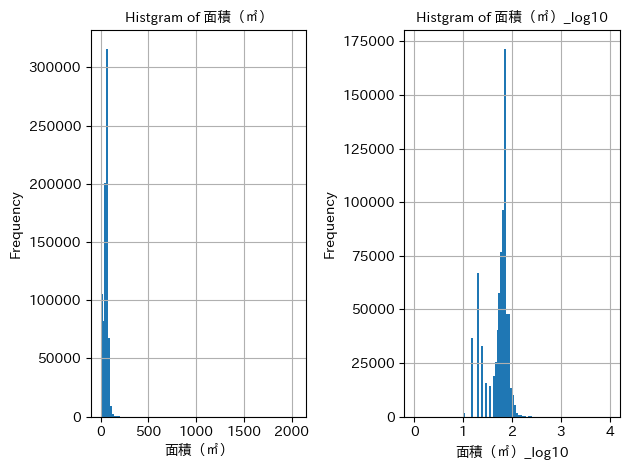

In [ ]:
# 面積（㎡）を対数変換

# 1つ目のグラフ
plt.subplot(1, 2, 1)
plt.xlabel("面積（㎡）", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Histgram of 面積（㎡）", fontsize=10)
plt.hist(x=df["面積（㎡）"], bins=100, range=(0, 2050))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# 2つ目のグラフ
plt.subplot(1, 2, 2)
df["面積（㎡）_log10"] = np.log10(df["面積（㎡）"])
plt.xlabel("面積（㎡）_log10", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Histgram of 面積（㎡）_log10", fontsize=10)
plt.hist(x=df["面積（㎡）_log10"], bins=100, range=(0, 4))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

#### ー 最寄駅：距離（分）を対数変換

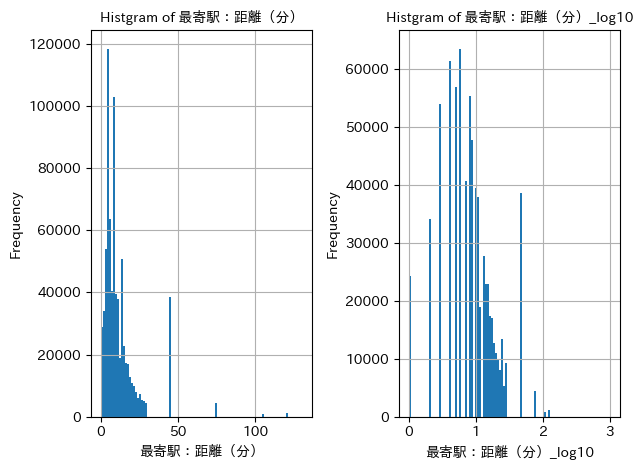

In [ ]:
# 最寄駅：距離（分）を対数変換

# 1つ目のグラフ
plt.subplot(1, 2, 1)
plt.xlabel("最寄駅：距離（分）", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Histgram of 最寄駅：距離（分）", fontsize=10)
plt.hist(x=df["最寄駅：距離（分）"], bins=100, range=(0, 130))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# ２つ目のグラフ
plt.subplot(1, 2, 2)
df["最寄駅：距離（分）_log10"] = np.log10(df["最寄駅：距離（分）"])
plt.xlabel("最寄駅：距離（分）_log10", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Histgram of 最寄駅：距離（分）_log10", fontsize=10)
plt.hist(x=df["最寄駅：距離（分）_log10"], bins=100, range=(0, 3))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# グラフを表示
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop('面積（㎡）', axis=1)
df = df.drop([ "最寄駅：距離（分）"], axis=1)

### label Encoding

In [ ]:
# ラベルエンコーディング関数定義
def label_encoding(df, cols):
  df[cols] = df[cols].fillna("0")

  # カラムを文字列型に変換
  df[cols] = df[cols].astype(str)
  
  le = LabelEncoder()
  
  for col in tqdm(cols, total=len(cols)):
    df[col] = le.fit_transform(df[col])
    
  return df

In [ ]:
# ラベルエンコーディング
cols = ['都道府県名',
        '地区名',
        '最寄駅：名称',
        '間取り',
        '建物の構造',
        '用途',
        '都市計画',
        '取引の事情等']
df = label_encoding(df, cols)
df.shape

  0%|          | 0/8 [00:00<?, ?it/s]

(784713, 23)

### CSV出力

In [ ]:
# ファイルを出力
df.to_csv(PATH + 'df.csv', index=False)